In [11]:
import setup_logger


ModuleNotFoundError: No module named 'setup_logger.py'; 'setup_logger' is not a package

In [23]:
import xarray as xr
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/phase-sensitive-radar-processing/code/ApRES_Python_Nicholls_2021")
import ApRESDefs
import importlib
importlib.reload(ApRESDefs) 
import ApRES_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
import glob
import gcsfs
import os
import logging
logger = logging.getLogger()
logger.propagate = False


#logging.basicConfig(filename='log.log', encoding='utf-8', level=numeric_level)
#logging.debug(f"Logging level set to {loglevel.upper()}")
#getattr(logging, loglevel.upper())
#logging.basicConfig(filename='log.log', encoding='utf-8', level=logging.DEBUG)

class xapres():
    def __init__(self, loglevel='warning', max_range = None):
        self._setup_logging(loglevel)
        self.max_range = max_range
    def load_single(self, dat_filename, remote_load=False, burst_number=0, chirp_num=0):
        """Load a single chirp, from a single burst, from a single data file."""
        
        self.files_to_be_processed = dat_filename
        self.logger.debug(f"Load dat file {dat_filename} with remote_load = {remote_load}")
        self.single_dat = self.load_dat_file(dat_filename,remote_load)
        self.logger.debug(f"Extract burst number {burst_number}")
        self.single_burst = self.single_dat.ExtractBurst(burst_number)
        self.logger.debug(f"Extract chirp number {chirp_num}")
        self.single_chirp = self.single_burst.ExtractChirp([chirp_num]) 
        self.logger.debug(f"Form profile for chirp number {chirp_num}")
        self.single_profile = self.single_chirp.FormProfile()
        self.logger.debug(f"Finish call to load_single.")
    
    def load_dat_file(self, dat_filename, remote_load=False):
        """Return a ApRESDefs.DataFileObject, given a filename."""
        return ApRESDefs.DataFileObject(dat_filename,remote_load)
    
    
    def list_files(self, directory=None, remote_load=False):    
        """Recursively list all the .DAT files in a given location dir. 
        
        Arguments:
        dir -- the directory that will be looked in recursivly to find .DAT files.
        remote_load -- True/False, indicating if the data are stored locally or rmeotely. Default is False.
        """

        self.logger.debug(f"Find all the dat files in the directory {directory} with remote_load = {remote_load}")

        
        if directory is None:
            directory = os.getcwd()
                        
        if remote_load:
            fs = gcsfs.GCSFileSystem()
            dat_filenames = fs.glob(directory + '/**/*.DAT', recursive = True)
        else:
            dat_filenames = glob.glob(directory + '/**/*.DAT',recursive = True)
        
        self.dat_filenames = dat_filenames
        
        self.logger.debug(f"Finish call to list_files. Found {len(dat_filenames)} files")

        
        return dat_filenames
       
    
    def load_all(self, directory=None, remote_load=False, file_numbers_to_process = "All", bursts_to_process = "All"):
        """Put all the data from all the .DAT files found recursively in 'directory', in one xarray."""
        self.file_numbers_to_process = file_numbers_to_process
        self.bursts_to_process = bursts_to_process
       
    
        ###### List files ######
        
        # find the dat files
        self.list_files(directory, remote_load)
        
        
        ###### Subset files ######
       
        
        self.logger.debug(f"Subset files to {file_numbers_to_process}")
        # choose which files to process (default is all of the files we found with list_files)
        if file_numbers_to_process == "All":
            self.dat_filenames_to_process = self.dat_filenames
        else:
            self.dat_filenames_to_process = [self.dat_filenames[i] for i in file_numbers_to_process]
                
        
        ## loop through the dat files, putting individual xarrays in a list
        self.logger.debug("Starting loop over dat files")
        list_of_multiBurstxarrays = []   
        for dat_filename in iter(self.dat_filenames_to_process):
            self.logger.debug(f"Load dat file {dat_filename}")

            dat = self.load_dat_file(dat_filename,remote_load)
            
            multiBurstxarray = self._all_bursts_in_dat_to_xarray(dat)
        
            list_of_multiBurstxarrays.append(multiBurstxarray)
        
        self.logger.debug(f"Contatenating all the multi-burst xarrays.")
        # contatenate all the xarrays in the list along the time dimension
        self.data = xr.concat(list_of_multiBurstxarrays,dim='time')     
        
        self._add_attrs()
        
        
        self.logger.debug(f"Finish call to load_all. Call xapres.data to see the xarray this produced.")
    
    def _all_bursts_in_dat_to_xarray(self,dat):
        """Take data from all the bursts in .DAT file and put it in an xarray.
        
        Argusments:
        dat -- a ApRESDefs.DataFileObject  
        """
        
        # choose which bursts to process (default is all of the burst in each dat file)
        if self.bursts_to_process == "All":
            self.bursts_to_process = range(0,dat.NoBurstsInFile)
        else:
            self.bursts_to_process = iter(self.bursts_to_process)
        
        self.logger.debug(f"Start loop over burst numbers {self.bursts_to_process} in dat file {dat.Filename}")
        list_of_singleBurst_xarrays = []
        for burst_number in tqdm(self.bursts_to_process):
            self.logger.debug(f"Extract burst number {burst_number}")
            burst = dat.ExtractBurst(burst_number)

            singleBurst_xarray = self._burst_to_xarray(burst)

            list_of_singleBurst_xarrays.append(singleBurst_xarray)
        self.logger.debug(f"Contatenating all the single-burst xarrays from dat file {dat.Filename}")
        return xr.concat(list_of_singleBurst_xarrays,dim='time') 
    
    def _burst_to_xarray(self,burst):
        """Return an xarray containing all data from one burst with appropriate coordinates"""
        self.logger.debug(f"Put all chirps and profiles from burst number {burst.BurstNo} in 3D arrays")
        chirps , profiles = self._burst_to_3d_arrays(burst)
        chirp_time, profile_range = self._coords_from_burst(burst)
        time = self._timestamp_from_burst(burst)

        chirps = chirps[None,:,:,:]
        profiles = profiles[None,:,:,:]

        xarray_out = xr.Dataset(
            data_vars=dict(
                chirp=(["time","chirp_time", "chirp_num", "attenuator_setting_pair"], chirps),
                profile=(["time", "profile_range", "chirp_num", "attenuator_setting_pair"], profiles),
                filename=(["time"], [burst.Filename]),
                burst_number=(["time"], [burst.BurstNo]),
            ),
            coords=dict(
                time = [time],
                chirp_time=chirp_time,
                profile_range=profile_range, 
                chirp_num = np.arange(burst.Header['NSubBursts']),
                AFGain=(["attenuator_setting_pair"], burst.Header['AFGain'][0:burst.Header['nAttenuators']]),
                attenuator=(["attenuator_setting_pair"], burst.Header['Attenuator1'][0:burst.Header['nAttenuators']]),
            ),
            attrs=dict(description="One burst in an xarray - chirps and profiles"),
        )
        return xarray_out
    
    def _burst_to_3d_arrays(self, burst):
        """Put all chirps and their corresponding profiles in 3D numpy arrays.
        
        First extract every chirp in a burst and compute a profile from each one. 
        
        Then put the results in two 3D numpy arrays. The 3D array for the chirp data (chirp_3d) has the following dimension lengths:
            - [1] burst.Header['N_ADC_SAMPLES'] (=40001, by default) --> number of samples in each chirp  
            - [2] burst.Header['NSubBursts'] --> the number of chirps per attenuator settingp pair 
            - [3] burst.Header['nAttenuators'] --> the number of attenuator settings. 
            
        The 3D array for the profile data (profile_3d) has the same lengths in the dimensions [2] and [3], but a differnt
        length of dimension [1], equal to the length of the profile obtained from the fft processing.
        
        Keyword arguments:
        burst -- a `BurstObject` produced by ApRESDefs.DataFileObject()
        max_range -- the range to use to crop profile_3d, float or int
        
        Returns: 
        chirp_3d -- 3D numpy array containing all the chirps in the supplied burst
        cropped_profile_3d -- 3D numpy array containing all the profiles from all the chirps in this burs        
        """
        
        self.logger.debug(f"Set max range from _burst_to_3d_arrays")
        self._set_max_range(burst)
        
        # pre-allocate 3D numpy arrays
        chirp_3d = np.zeros((burst.Header['N_ADC_SAMPLES'],burst.Header['NSubBursts'],burst.Header['nAttenuators']))
        test_profile = burst.ExtractChirp([0]).FormProfile()
        profile_3d = np.zeros((len(test_profile.Profile),burst.Header['NSubBursts'],burst.Header['nAttenuators']), dtype=complex)
    
        # initialize counters for second and third dimensions of our 3D arrays respectively 
        chirp_counter = 0
        setting_counter = 0
        
        # loop over all chirps in this burst
        for i in np.arange(burst.Header['NChirps']):
            chirp_new = burst.ExtractChirp([i]) 
            profile_new = chirp_new.FormProfile()

            chirp_3d[:,chirp_counter,setting_counter] = chirp_new.vdat
            profile_3d[:,chirp_counter,setting_counter] = profile_new.Profile  

            # keep track of which pair of settings we are using
            setting_counter += 1
            if setting_counter >= burst.Header['nAttenuators']: # if the counter reaches nAttenuators, reset it to zero 
                setting_counter = 0
                chirp_counter += 1

        # crop the profile to a reasonable depth to save space 
        n = np.argmin(profile_new.Range<=self.max_range)
        cropped_profile_3d = profile_3d[:n,:,:]    

        return chirp_3d, cropped_profile_3d

    def _coords_from_burst(self, burst):
        """Return the time vector and depth vector from the first chirp in a burst. They should be the same for the whole burst."""
        
        self.logger.debug(f"Set max range from _coords_from_burst")
        self._set_max_range(burst)
        
        chirp = burst.ExtractChirp([0])

        profile = chirp.FormProfile()
        n = np.argmin(profile.Range<=self.max_range)
        cropped_range = profile.Range[:n] 
        return  chirp.t, cropped_range

    def _timestamp_from_burst(self,burst):
        """Return the time stamp of a burst"""  
        return pd.to_datetime(burst.Header["Time stamp"])  
    
    def _set_max_range(self,burst):
        
        # if not supplied with a max_range, use what is defined in the header
        if self.max_range is None:
            self.max_range = burst.Header['maxDepthToGraph']
        else: 
            self.max_range = self.max_range 
        self.logger.debug(f"Max_range has been set to {self.max_range}")
 
    def _add_attrs(self):
        self.logger.debug("_add_attrs currently doesnt do anything, but it should add long_name, units, and provenance information to the data variables and coordinates in the final xapres")

    def dB(self):
        return 20*np.log10(np.abs(self.data.profile))
    
    def _setup_logging(self,loglevel):
        numeric_level = getattr(logging, loglevel.upper(), None)
        if not isinstance(numeric_level, int):
            raise ValueError('Invalid log level: %s' % loglevel)


        self.logger = logging.getLogger("default_logger")
        # Clear old logging handlers to avoid a build up of multiple similar handlers with repeat calls
        self.logger.handlers.clear()
        
        # Set stream logging level to loglevel
        self.logger.setLevel(level=numeric_level)
        

        logStreamFormatter = logging.Formatter(
            fmt=f"%(levelname)-8s %(asctime)s \t %(filename)s @function %(funcName)s line %(lineno)s - %(message)s", 
            datefmt="%H:%M:%S"
        )
        consoleHandler = logging.StreamHandler(stream=sys.stdout)
        consoleHandler.setFormatter(logStreamFormatter)
        consoleHandler.setLevel(level=numeric_level)
               
        
        self.logger.addHandler(consoleHandler)
        
        self.logger.debug(f"Stream logging level set to {loglevel.upper()}")
        self.logger.debug('Add console handler to logger')
     
           
        logFileFormatter = logging.Formatter(
            fmt=f"%(levelname)s %(asctime)s (%(relativeCreated)d) \t %(pathname)s F%(funcName)s L%(lineno)s - %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        fileHandler = logging.FileHandler(filename='test6.log')
        fileHandler.setFormatter(logFileFormatter)
        fileHandler.setLevel(level=numeric_level)

        self.logger.addHandler(fileHandler)
        
        self.logger.debug(f"File logging level set to {loglevel.upper()}")
   
        
    def _try_logging(self):
        """Simple test of the deffrent logging levels. Not for use by users"""
        self.logger.debug("debugging something")
        self.logger.info("some message")
        self.logger.error("something went wrong")
        
apres_1 = xapres(loglevel='debug', max_range = 1400)

apres_1.load_all(directory = 'gs://ldeo-glaciology/GL_apres_2022/A101', remote_load=True, file_numbers_to_process = [0], bursts_to_process = [0])  
apres_1.data

DEBUG    22:41:57 	 592250140.py @function _setup_logging line 286 - Stream logging level set to DEBUG
DEBUG    22:41:57 	 592250140.py @function _setup_logging line 287 - Add console handler to logger
DEBUG    22:41:57 	 592250140.py @function _setup_logging line 300 - File logging level set to DEBUG
DEBUG    22:41:57 	 592250140.py @function list_files line 57 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022/A101 with remote_load = True
DEBUG    22:41:57 	 592250140.py @function list_files line 71 - Finish call to list_files. Found 127 files
DEBUG    22:41:57 	 592250140.py @function load_all line 92 - Subset files to [0]
DEBUG    22:41:57 	 592250140.py @function load_all line 101 - Starting loop over dat files
DEBUG    22:41:57 	 592250140.py @function load_all line 104 - Load dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
DEBUG    22:42:01 	 592250140.py @function _all_bursts_in_dat_to_xarray line 134 - Star

0it [00:00, ?it/s]

DEBUG    22:42:01 	 592250140.py @function _all_bursts_in_dat_to_xarray line 137 - Extract burst number 0
DEBUG    22:42:02 	 592250140.py @function _burst_to_xarray line 148 - Put all chirps and profiles from burst number 0 in 3D arrays
DEBUG    22:42:02 	 592250140.py @function _burst_to_3d_arrays line 197 - Set max range from _burst_to_3d_arrays
DEBUG    22:42:02 	 592250140.py @function _set_max_range line 253 - Max_range has been set to 1400
DEBUG    22:42:03 	 592250140.py @function _coords_from_burst line 232 - Set max range from _coords_from_burst
DEBUG    22:42:03 	 592250140.py @function _set_max_range line 253 - Max_range has been set to 1400


1it [00:02,  2.91s/it]

DEBUG    22:42:03 	 592250140.py @function _all_bursts_in_dat_to_xarray line 143 - Contatenating all the single-burst xarrays from dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
DEBUG    22:42:04 	 592250140.py @function load_all line 112 - Contatenating all the multi-burst xarrays.
DEBUG    22:42:04 	 592250140.py @function _add_attrs line 256 - _add_attrs currently doesnt do anything, but it should add long_name, units, and provenance information to the data variables and coordinates in the final xapres
DEBUG    22:42:04 	 592250140.py @function load_all line 119 - Finish call to load_all. Call xapres.data to see the xarray this produced.


<xarray.Dataset>
Dimensions:        (time: 1, chirp_time: 40001, chirp_num: 20,
                    attenuator_setting_pair: 2, profile_range: 6658)
Coordinates:
  * time           (time) datetime64[ns] 2022-05-22T19:40:20
  * chirp_time     (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    AFGain         (attenuator_setting_pair) int64 -14 -14
    attenuator     (attenuator_setting_pair) float64 10.0 20.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp          (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile        (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2...
    burst_number   (time) int64 0
Attributes:
    description:  One burst in an xarray - chirps and profiles

Load a single burst from the first dat file.

In [31]:
apresXR = apresarray(loglevel='debug')
filepaths = apresXR.list_files('gs://ldeo-glaciology/GL_apres_2022/A101',remote_load=True)
apresXR.load_single(filepaths[0], remote_load=True)

DEBUG    22:50:54 	 3601821916.py @function _setup_logging line 280 - Stream logging level set to DEBUG
DEBUG    22:50:54 	 3601821916.py @function _setup_logging line 281 - Add console handler to logger
DEBUG    22:50:54 	 3601821916.py @function _setup_logging line 294 - File logging level set to DEBUG
DEBUG    22:50:54 	 3601821916.py @function list_files line 57 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022/A101 with remote_load = True
DEBUG    22:50:55 	 3601821916.py @function list_files line 71 - Finish call to list_files. Found 127 files
DEBUG    22:50:55 	 3601821916.py @function load_single line 34 - Load dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT with remote_load = True
DEBUG    22:51:12 	 3601821916.py @function load_single line 36 - Extract burst number 0
DEBUG    22:51:18 	 3601821916.py @function load_single line 38 - Extract chirp number 0
DEBUG    22:51:18 	 3601821916.py @function load_si

0

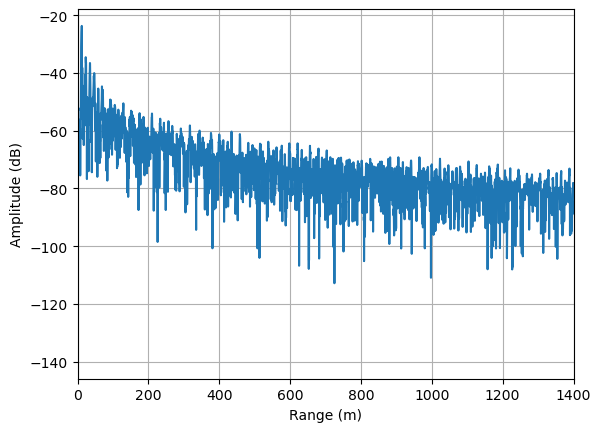

In [34]:
apresXR.single_profile.PlotProfile(1400)

Let's find all the files from the unit A101 on the google bucket.

In [5]:
apresXR = apresarray(loglevel='debug')
filepaths = apresXR.list_files('gs://ldeo-glaciology/GL_apres_2022/A101',remote_load=True)
filepaths

DEBUG    16:50:48 	 1437972915.py @function _setup_logging line 271 - Stream logging level set to DEBUG
DEBUG    16:50:48 	 1437972915.py @function _setup_logging line 272 - Add console handler to logger
DEBUG    16:50:48 	 1437972915.py @function _setup_logging line 285 - File logging level set to DEBUG
DEBUG    16:50:48 	 1437972915.py @function list_files line 56 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022/A101 with remote_load = True
DEBUG    16:50:48 	 1437972915.py @function list_files line 70 - Finish call to list_files. Found 127 files


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-26-1536.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-27-1506.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-28-1436.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-29-1406.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-30-1336.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-31-1306.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-01-1236.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-02-1206.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-03-1136.DAT',
 'ldeo-glaciology/GL_apres_2022/

It looks like the first file in there is not part of the same sequence. Maybe it was run in town, rather than on the ice sheet. This probably explains the plot above which does not show the bed. We should add lat and lon (and maybe temp) to the xarray in a future version. 